# Libraries

In [1]:
import matplotlib.pyplot as plt
import yaml
import time
import re
import os
import numpy as np
import librosa
import models
import torch
import torch.nn as nn
import torch.optim as optimizer
import matplotlib.pyplot as plt

from scipy.stats import gamma
from data_bundler import DataBundler
from dataset_downloader import DatasetDownloader
from torch.utils.data import DataLoader
from torch.nn.functional import mse_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib.backends.backend_pdf import PdfPages

# Download Datasets

In [2]:
# dataset_downloader = DatasetDownloader()
# dataset_downloader.download_datasets("download_paths_2025.yaml")

# Hyper Parameters

In [3]:
def load_hyper_parameters():
    with open("hyper_parameters.yaml", 'r') as file:
        return yaml.safe_load(file)

In [4]:
hyper_parameters = load_hyper_parameters()

#> Acoustic Features
acoustic_features = hyper_parameters['acoustic_features']
number_of_mels = acoustic_features['number_of_mels']
number_of_frames_to_concatenate = acoustic_features['number_of_frames_to_concatenate']
frame_size_seconds = acoustic_features['frame_size_seconds']
frame_size_samples = acoustic_features['frame_size_samples']
hop_size_seconds = acoustic_features['hop_size_seconds']
hop_size_samples = acoustic_features['hop_size_samples']


#> Dataset Parameters
dataset_paremeters = hyper_parameters['dataset_parameters']
train_data_inclusion_string = dataset_paremeters['train_data_inclusion_string']
test_data_inclusion_string = dataset_paremeters['test_data_inclusion_string']
train_pct = dataset_paremeters['train_pct']
test_pct = dataset_paremeters['test_pct']
print(train_data_inclusion_string)
print(test_data_inclusion_string)
print(train_pct)
print(test_pct)

#> Training Parameters
training_parameters = hyper_parameters['training_parameters']
batch_size = training_parameters['batch_size']
epochs = training_parameters['epochs']
learning_rate = training_parameters['learning_rate']
shuffle = training_parameters['shuffle']

train
bearing\test
1
1


# Loading Datasets

In [5]:
data_bundler = DataBundler()
number_of_top_frequiences = 10

print("Training Data")
training_data, training_filenames, training_clip_lengths = data_bundler.load_dataset(inclusion_string=train_data_inclusion_string, include_supplemental=True, percentage=train_pct)
number_of_training_data = len(training_data)

Training Data


Processing audio files: 100%|██████████| 16500/16500 [01:57<00:00, 140.62file/s]


Done loading!
Length of dataset: 941584



# Selecting Device

In [6]:
!nvidia-smi

Sun Jun 15 23:03:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0  On |                  N/A |
| 56%   33C    P8             10W /   75W |    1010MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

if torch.cuda.is_available():
    # Check if CUDA device 2 is available
    if torch.cuda.device_count() > 2:
        device = torch.device("cuda:2")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1650
Using device: cuda:0


# Training

In [8]:
model = models.BaselineAutoencoder().to(device)
# model.load_state_dict(torch.load("saved_models/first_final_model.pth"))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training_dataset = torch.tensor(training_data, dtype=torch.float32)
training_input_features = DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)

In [9]:
data_bundler = DataBundler()

print("Validation Data")
validation_data, validation_filenames, validation_clip_lengths = data_bundler.load_dataset(inclusion_string=test_data_inclusion_string, include_supplemental=False, percentage=test_pct)
number_of_validation_data_data = len(validation_data)

validation_dataset = torch.tensor(validation_data, dtype=torch.float32)
validation_input_features = DataLoader(validation_dataset, batch_size=batch_size, shuffle=shuffle)

Validation Data


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 166.62file/s]

Done loading!
Length of dataset: 12400



In [10]:
training_losses = []
validation_losses = []

def train_model():
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        # Training loop
        for data in training_input_features:
            input = data.to(device)
            optimizer.zero_grad()

            output = model(input)
            loss = criterion(output, input)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_training_loss = total_loss / len(training_input_features)
        training_losses.append(avg_training_loss)

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_data in validation_input_features:
                val_input = val_data.to(device)
                val_output = model(val_input)
                val_loss = criterion(val_output, val_input)
                total_val_loss += val_loss.item()

        avg_validation_loss = total_val_loss / len(validation_input_features)
        validation_losses.append(avg_validation_loss)

        elapsed_time = time.time() - start_time
        print(f"Epoch [{epoch + 1}/{epochs}] ({elapsed_time:.2f}s) | "
              f"Train Loss: {avg_training_loss:.4f} | Val Loss: {avg_validation_loss:.4f}")

    model.eval()


In [11]:
train_model()

Epoch [1/50] (43.73s) | Train Loss: 42.1545 | Val Loss: 16.6552
Epoch [2/50] (85.92s) | Train Loss: 13.9230 | Val Loss: 14.5327
Epoch [3/50] (128.64s) | Train Loss: 12.8638 | Val Loss: 14.0707
Epoch [4/50] (171.16s) | Train Loss: 12.3126 | Val Loss: 13.8958
Epoch [5/50] (213.32s) | Train Loss: 12.0266 | Val Loss: 14.0294
Epoch [6/50] (255.56s) | Train Loss: 11.8388 | Val Loss: 13.4063
Epoch [7/50] (297.78s) | Train Loss: 11.7095 | Val Loss: 13.3136
Epoch [8/50] (340.31s) | Train Loss: 11.6140 | Val Loss: 13.4894
Epoch [9/50] (382.64s) | Train Loss: 11.5427 | Val Loss: 13.3096
Epoch [10/50] (426.36s) | Train Loss: 11.5059 | Val Loss: 13.6473
Epoch [11/50] (471.99s) | Train Loss: 11.4384 | Val Loss: 13.1949
Epoch [12/50] (517.85s) | Train Loss: 11.3961 | Val Loss: 13.2236
Epoch [13/50] (563.48s) | Train Loss: 11.3744 | Val Loss: 13.4840
Epoch [14/50] (609.38s) | Train Loss: 11.3333 | Val Loss: 13.5855
Epoch [15/50] (654.96s) | Train Loss: 11.3128 | Val Loss: 13.1870
Epoch [16/50] (701.08

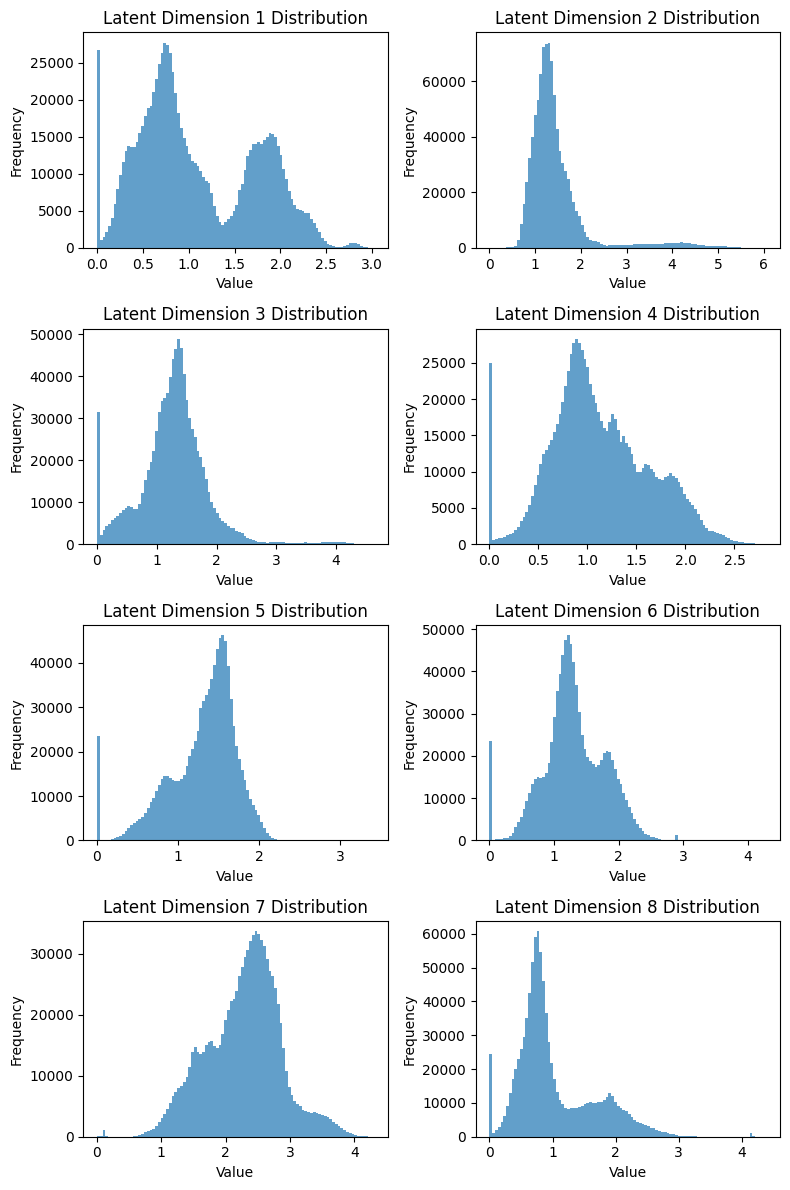

In [12]:
# Collect encoded batches
encoded_batches = []

for batch in training_input_features:  # Assuming testing_input_features is a DataLoader
    batch = batch.to(device)  # Move tensor batch to device
    encoded_batch = model.encoder(batch).detach().cpu().numpy()
    encoded_batches.append(encoded_batch)

encoded_data = np.concatenate(encoded_batches, axis=0)

# Determine the number of latent dimensions
num_dimensions = encoded_data.shape[1]

# Calculate number of columns (4 rows)
num_columns = (num_dimensions + 3) // 4  # Round up for odd dimensions

# Create subplots with 4 rows
fig, axes = plt.subplots(4, num_columns, figsize=(num_columns * 4, 12), sharex=False)
axes = axes.flatten()  # Flatten to simplify indexing

for i in range(num_dimensions):
    axes[i].hist(encoded_data[:, i], bins=100, alpha=0.7)
    axes[i].set_title(f"Latent Dimension {i + 1} Distribution")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots
for j in range(num_dimensions, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

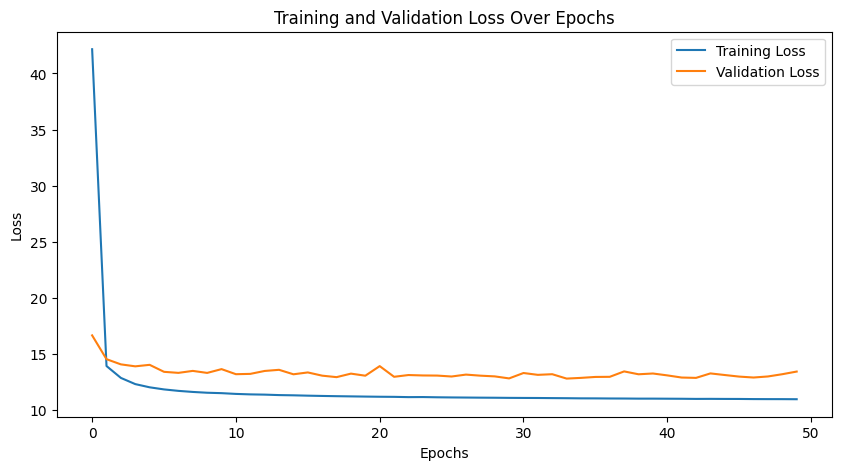

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()


# Evaluating

In [14]:
hyper_parameters = load_hyper_parameters()

#> Acoustic Features
acoustic_features = hyper_parameters['acoustic_features']
number_of_mels = acoustic_features['number_of_mels']
number_of_frames_to_concatenate = acoustic_features['number_of_frames_to_concatenate']
frame_size_seconds = acoustic_features['frame_size_seconds']
frame_size_samples = acoustic_features['frame_size_samples']
hop_size_seconds = acoustic_features['hop_size_seconds']
hop_size_samples = acoustic_features['hop_size_samples']


#> Dataset Parameters
dataset_paremeters = hyper_parameters['dataset_parameters']
train_data_inclusion_string = dataset_paremeters['train_data_inclusion_string']
test_data_inclusion_string = dataset_paremeters['test_data_inclusion_string']
train_pct = dataset_paremeters['train_pct']
test_pct = dataset_paremeters['test_pct']
print(train_data_inclusion_string)
print(test_data_inclusion_string)
print(train_pct)
print(test_pct)

#> Training Parameters
training_parameters = hyper_parameters['training_parameters']
batch_size = training_parameters['batch_size']
epochs = training_parameters['epochs']
learning_rate = training_parameters['learning_rate']
shuffle = training_parameters['shuffle']

train
bearing\test
1
1


In [15]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

if torch.cuda.is_available():
    # Check if CUDA device 2 is available
    if torch.cuda.device_count() > 2:
        device = torch.device("cuda:2")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

CUDA available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1650
Using device: cuda:0


In [16]:
# ----------------------------------------
# SKIP IF NEWLY TRAINED MODEL!!
# ----------------------------------------
# model = models.BaselineAutoencoder()
# model.load_state_dict(torch.load("saved_models/first_final_model.pth"))

In [17]:
data_bundler = DataBundler()

print("Testing Data")
# my_inclusion_string = "Evaluation\\AutoTrash\\test"
# my_test_pct = 1
testing_data, testing_filenames, testing_clip_lengths = data_bundler.load_dataset(inclusion_string=test_data_inclusion_string, include_supplemental=False, percentage=test_pct)

number_of_testing_data = len(testing_data)
testing_filenames

Testing Data


Processing audio files: 100%|██████████| 200/200 [00:01<00:00, 168.34file/s]

Done loading!
Length of dataset: 12400



['section_00_target_test_anomaly_0032_noAttribute.wav',
 'section_00_target_test_anomaly_0046_noAttribute.wav',
 'section_00_source_test_anomaly_0025_noAttribute.wav',
 'section_00_target_test_anomaly_0001_noAttribute.wav',
 'section_00_target_test_normal_0035_noAttribute.wav',
 'section_00_target_test_normal_0042_noAttribute.wav',
 'section_00_source_test_normal_0005_noAttribute.wav',
 'section_00_target_test_anomaly_0043_noAttribute.wav',
 'section_00_target_test_anomaly_0028_noAttribute.wav',
 'section_00_source_test_normal_0025_noAttribute.wav',
 'section_00_source_test_normal_0038_noAttribute.wav',
 'section_00_target_test_normal_0002_noAttribute.wav',
 'section_00_target_test_anomaly_0047_noAttribute.wav',
 'section_00_target_test_anomaly_0017_noAttribute.wav',
 'section_00_source_test_anomaly_0033_noAttribute.wav',
 'section_00_target_test_normal_0003_noAttribute.wav',
 'section_00_source_test_anomaly_0004_noAttribute.wav',
 'section_00_source_test_normal_0032_noAttribute.wav',


In [18]:
testing_dataset = torch.tensor(testing_data, dtype=torch.float32)
testing_input_features = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# # Collect encoded batches
# encoded_batches = []

# for batch in testing_input_features:  # Assuming testing_input_features is a DataLoader
#     batch = batch.to(device)  # Move tensor batch to device
#     encoded_batch = model.encoder(batch).detach().cpu().numpy()
#     encoded_batches.append(encoded_batch)

# encoded_data = np.concatenate(encoded_batches, axis=0)

# # Determine the number of latent dimensions
# num_dimensions = encoded_data.shape[1]

# # Calculate number of columns (4 rows)
# num_columns = (num_dimensions + 3) // 4  # Round up for odd dimensions

# # Create subplots with 4 rows
# fig, axes = plt.subplots(4, num_columns, figsize=(num_columns * 4, 12), sharex=False)
# axes = axes.flatten()  # Flatten to simplify indexing

# for i in range(num_dimensions):
#     axes[i].hist(encoded_data[:, i], bins=100, alpha=0.7)
#     axes[i].set_title(f"Latent Dimension {i + 1} Distribution")
#     axes[i].set_xlabel("Value")
#     axes[i].set_ylabel("Frequency")

# # Hide any unused subplots
# for j in range(num_dimensions, len(axes)):
#     axes[j].axis('off')

# # Adjust layout to prevent overlap
# plt.tight_layout()
# plt.show()

In [20]:
def evaluate_model(testing_input_features, model):
    testing_output_features = []
    mse_list = []

    model.eval()
    total_mse = 0.0
    total_samples = 0

    device = next(model.parameters()).device

    with torch.no_grad():
        for data in testing_input_features:
            input = data.to(device)
            output = model(input)

            testing_output_features.append(output.cpu().numpy())  # Store the reconstruction for later use

            mse = mse_loss(output, input, reduction='sum').item()
            mse_list.append(mse)
            total_mse += mse
            total_samples += input.numel()
            
    average_mse = total_mse / total_samples
    #print(f"Average MSE: {average_mse:.4f}")

    return average_mse, testing_output_features

In [21]:
average_mse, testing_output_features = evaluate_model(testing_input_features, model)
testing_output_features = np.vstack(testing_output_features)

In [22]:
testing_data

array([[-10.453066 ,  -8.149256 , -12.720736 , ..., -42.266373 ,
        -44.652176 , -43.12835  ],
       [-11.468903 ,  -8.42375  ,  -8.752787 , ..., -34.23561  ,
        -37.000114 , -38.46717  ],
       [ -9.967978 ,  -7.1881847, -14.1770115, ..., -34.59861  ,
        -39.334206 , -37.59053  ],
       ...,
       [-19.417318 , -15.524176 ,  -9.318245 , ..., -30.028433 ,
        -27.982641 , -28.463709 ],
       [ -7.425869 , -13.96817  , -10.393993 , ..., -29.320192 ,
        -33.35341  , -35.46263  ],
       [-15.492292 , -17.739862 , -13.692282 , ..., -33.037064 ,
        -35.970467 , -35.00438  ]], shape=(12400, 640), dtype=float32)

In [23]:
testing_output_features

array([[-15.481735, -15.315342, -15.064213, ..., -42.926132, -41.93006 ,
        -41.889816],
       [-13.465998, -13.412685, -13.226864, ..., -38.463936, -38.555027,
        -38.355415],
       [-14.546915, -14.463455, -14.29859 , ..., -37.00074 , -36.92521 ,
        -36.767303],
       ...,
       [-15.858244, -15.748071, -15.60275 , ..., -34.428696, -34.347145,
        -34.889957],
       [-15.080449, -14.941923, -14.819199, ..., -34.313946, -34.40069 ,
        -34.500984],
       [-16.773531, -16.709232, -16.659191, ..., -38.174957, -38.03031 ,
        -37.90777 ]], shape=(12400, 640), dtype=float32)

In [24]:
# np.mean((testing_data - testing_output_features)**2)

## Reconstructions

In [25]:
original_clips = []

start_index = 0

for size in testing_clip_lengths:
    end_index = start_index + size
    original_clips.append(testing_data[start_index:end_index])
    start_index = end_index

In [26]:
original_clips[0]

array([[-10.453066 ,  -8.149256 , -12.720736 , ..., -42.266373 ,
        -44.652176 , -43.12835  ],
       [-11.468903 ,  -8.42375  ,  -8.752787 , ..., -34.23561  ,
        -37.000114 , -38.46717  ],
       [ -9.967978 ,  -7.1881847, -14.1770115, ..., -34.59861  ,
        -39.334206 , -37.59053  ],
       ...,
       [-24.151949 , -17.346312 , -12.111715 , ..., -36.76375  ,
        -34.970894 , -33.75486  ],
       [-11.54497  , -13.261133 , -10.910818 , ..., -35.471085 ,
        -34.953255 , -32.18718  ],
       [-10.670532 , -13.292873 , -14.031805 , ..., -32.914757 ,
        -32.580933 , -34.065735 ]], shape=(62, 640), dtype=float32)

In [27]:
reconstructed_clips = []
start_index = 0

for size in testing_clip_lengths:
    end_index = start_index + size
    reconstructed_clips.append(testing_output_features[start_index:end_index])
    start_index = end_index

reconstructed_clips[0]

array([[-15.481735, -15.315342, -15.064213, ..., -42.926132, -41.93006 ,
        -41.889816],
       [-13.465998, -13.412685, -13.226864, ..., -38.463936, -38.555027,
        -38.355415],
       [-14.546915, -14.463455, -14.29859 , ..., -37.00074 , -36.92521 ,
        -36.767303],
       ...,
       [-14.966367, -14.964419, -14.803385, ..., -36.509808, -36.47328 ,
        -37.093575],
       [-16.134724, -16.124762, -15.986221, ..., -36.763535, -36.72671 ,
        -37.417137],
       [-14.434898, -14.416358, -14.252495, ..., -36.272873, -36.209846,
        -36.754917]], shape=(62, 640), dtype=float32)

In [28]:
recon_err_per_clip = []
for i in range(len(reconstructed_clips)):
    item1 = reconstructed_clips[i].reshape(-1)
    item2 = original_clips[i].reshape(-1)
    
    recon_err_per_clip.append(np.mean((item1 - item2)**2))

In [29]:
indices_sorted = np.argsort(recon_err_per_clip)[::-1]  # Indices sorted by value in descending order

print(indices_sorted[0])  # Index of the largest value
print(indices_sorted[1])  # Index of the second largest value
print(indices_sorted[2])  # Index of the third largest value

129
162
50


In [30]:
# highest_recon_err_index = np.argmax(recon_err_per_clip)
# print("Highest reconstruction error index:", highest_recon_err_index)
# recon_err_per_clip[highest_recon_err_index]

In [31]:
# clip = original_clips[0]  # shape (65, 650)

# # Extract last 10 columns
# last_top_columns = clip[:, -number_of_top_frequiences:]  # shape (65, 10)

# # Convert each column to a single value (e.g., mean across rows)
# last_top_list = list(np.mean(last_top_columns, axis=0))  # length 10 list

# # Keep the first 640 columns
# clip_trimmed = clip[:, :-number_of_top_frequiences]  # shape (65, 640)

# print(clip_trimmed.shape)  # (65, 640)
# print(len(last_top_list))   # 10


In [32]:
from audio_converter import AudioConverter
audio_converter = AudioConverter()

audio_clip_index = indices_sorted[8]

original_input = audio_converter.output_to_mel(original_clips[audio_clip_index])
original_input

array([[-17.630075 , -20.437239 ,  -7.1539154, ..., -20.918978 ,
        -20.040823 , -13.24362  ],
       [-20.114092 , -15.220358 , -11.631472 , ..., -11.992073 ,
        -12.369299 , -10.573038 ],
       [-21.2792   , -13.128637 , -14.987535 , ..., -13.826065 ,
        -12.527918 , -17.286486 ],
       ...,
       [-26.839708 , -23.933558 , -24.516787 , ..., -27.299482 ,
        -25.101511 , -25.380331 ],
       [-28.749163 , -21.987696 , -26.1709   , ..., -28.188166 ,
        -27.493578 , -25.98171  ],
       [-34.8453   , -27.823923 , -31.541414 , ..., -29.728113 ,
        -31.408136 , -31.982458 ]], shape=(128, 310), dtype=float32)

In [33]:
# clip = reconstructed_clips[0]  # shape (65, 650)

# # Extract last 10 columns
# last_10_columns = clip[:, -10:]  # shape (65, 10)

# # Convert each column to a single value (e.g., mean across rows)
# last_10_list = list(np.mean(last_10_columns, axis=0))  # length 10 list

# # Keep the first 640 columns
# clip_trimmed = clip[:, :-10]  # shape (65, 640)

# print(clip_trimmed.shape)  # (65, 640)
# print(len(last_10_list))   # 10


In [34]:
recreated_output = audio_converter.output_to_mel(reconstructed_clips[audio_clip_index])
recreated_output

array([[-16.103434 , -15.8848095, -15.794327 , ..., -15.271181 ,
        -15.225903 , -15.306708 ],
       [-13.968004 , -13.941633 , -13.873095 , ..., -13.40649  ,
        -13.11611  , -13.119064 ],
       [-16.696423 , -16.531801 , -16.523033 , ..., -16.362837 ,
        -16.11571  , -16.166931 ],
       ...,
       [-29.83255  , -29.615223 , -29.75954  , ..., -30.529753 ,
        -30.40211  , -30.540956 ],
       [-29.048218 , -28.666756 , -28.953688 , ..., -29.344418 ,
        -29.242123 , -29.523552 ],
       [-30.138477 , -29.529163 , -29.804396 , ..., -29.144646 ,
        -28.943077 , -29.381208 ]], shape=(128, 310), dtype=float32)

In [35]:
error_mel = original_input - recreated_output
error_mel

array([[-1.5266418, -4.552429 ,  8.640411 , ..., -5.6477966, -4.8149204,
         2.0630884],
       [-6.1460876, -1.2787247,  2.241623 , ...,  1.4144173,  0.7468109,
         2.5460262],
       [-4.582777 ,  3.403164 ,  1.5354977, ...,  2.5367718,  3.5877914,
        -1.1195545],
       ...,
       [ 2.9928417,  5.6816654,  5.242754 , ...,  3.2302704,  5.300598 ,
         5.1606255],
       [ 0.2990551,  6.67906  ,  2.7827873, ...,  1.1562519,  1.7485447,
         3.5418415],
       [-4.7068214,  1.7052402, -1.7370186, ..., -0.5834675, -2.4650593,
        -2.6012497]], shape=(128, 310), dtype=float32)

In [36]:
audio_clip_index = indices_sorted[len(indices_sorted)-9]

original_input_2 = audio_converter.output_to_mel(original_clips[audio_clip_index])
original_input_2

array([[-11.564712 , -18.832764 , -19.07082  , ..., -12.650575 ,
        -15.091914 , -22.495342 ],
       [ -7.2070665, -12.747287 , -17.162365 , ...,  -6.262801 ,
        -10.668668 , -18.334824 ],
       [ -7.4568357, -14.027009 , -12.759688 , ..., -12.681386 ,
        -11.57105  , -16.793442 ],
       ...,
       [-37.574352 , -36.394962 , -35.325188 , ..., -34.496975 ,
        -37.01378  , -35.92596  ],
       [-39.126858 , -35.338837 , -35.69902  , ..., -35.54274  ,
        -32.865383 , -35.482635 ],
       [-40.408543 , -33.988117 , -37.52672  , ..., -39.199203 ,
        -37.64855  , -38.971478 ]], shape=(128, 310), dtype=float32)

In [37]:
recreated_output_2 = audio_converter.output_to_mel(reconstructed_clips[audio_clip_index])
recreated_output_2

array([[-17.64536 , -17.611664, -17.483309, ..., -16.86019 , -16.994522,
        -16.972748],
       [ -9.983612,  -9.855885,  -9.792859, ..., -12.8321  , -12.762455,
        -12.757668],
       [ -9.029019,  -8.882269,  -9.056472, ..., -13.283389, -13.190116,
        -13.3462  ],
       ...,
       [-40.176018, -40.249996, -40.433777, ..., -39.585945, -39.810272,
        -39.7862  ],
       [-40.15589 , -40.18859 , -40.5197  , ..., -39.03868 , -39.278206,
        -39.38417 ],
       [-41.829956, -41.77996 , -42.11384 , ..., -41.000732, -41.245293,
        -41.643475]], shape=(128, 310), dtype=float32)

In [38]:
error_mel_2 = original_input_2 - recreated_output_2
error_mel_2

array([[ 6.0806494, -1.2210999, -1.5875111, ...,  4.2096148,  1.9026079,
        -5.5225945],
       [ 2.7765455, -2.8914022, -7.369506 , ...,  6.5692987,  2.0937872,
        -5.577156 ],
       [ 1.5721836, -5.14474  , -3.7032166, ...,  0.6020031,  1.6190662,
        -3.4472418],
       ...,
       [ 2.6016655,  3.8550339,  5.108589 , ...,  5.08897  ,  2.7964935,
         3.860241 ],
       [ 1.0290337,  4.8497543,  4.8206787, ...,  3.4959412,  6.4128227,
         3.901535 ],
       [ 1.4214134,  7.7918434,  4.58712  , ...,  1.8015289,  3.5967445,
         2.671997 ]], shape=(128, 310), dtype=float32)

In [39]:
# from audio_converter import AudioConverter
# audio_converter = AudioConverter()

# audio_clip_index = 0

# original_input = audio_converter.output_to_mel(original_clips[audio_clip_index])
# recreated_output = audio_converter.output_to_mel(reconstructed_clips[audio_clip_index])

# error_mel = original_input - recreated_output

In [40]:
# # Create a 3-row, 2-column layout for the spectrogram plots
# spectrogram_figures, axes = plt.subplots(3, 2, figsize=(10, 15), sharex=True, sharey=True)

# # Plot each spectrogram
# spectrograms = [original_input, original_input_2, recreated_output, recreated_output_2, error_mel, error_mel_2]
# titles = ['Original Input', 'Original Input 2', 'Reconstructed Output', 'Reconstructed Output 2', 'Difference', 'Difference 2']
# flat_axes = axes.flatten()  # Flatten axes to handle a 1D array

# for i, (spectrogram, title) in enumerate(zip(spectrograms, titles)):
#     img = librosa.display.specshow(
#         spectrogram,
#         sr=16000,
#         x_axis='time',
#         y_axis='mel',
#         cmap='magma',
#         ax=flat_axes[i]
#     )
#     flat_axes[i].set_title(title)
#     flat_axes[i].set_xlabel('Time')
#     flat_axes[i].set_ylabel('Frequency (Hz)')

# # Hide unused subplots
# for j in range(len(spectrograms), len(flat_axes)):
#     spectrogram_figures.delaxes(flat_axes[j])

# # Add a colorbar beside the plots
# cbar_ax = spectrogram_figures.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# cbar = spectrogram_figures.colorbar(img, cax=cbar_ax, format='%+2.0f dB')
# cbar.set_label('Amplitude (dB)')

# # Adjust layout to prevent overlap
# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for the color bar
# plt.show()

# # Print the filename associated with the spectrogram
# print(testing_filenames[audio_clip_index])


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_24384\3767106227.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for the color bar


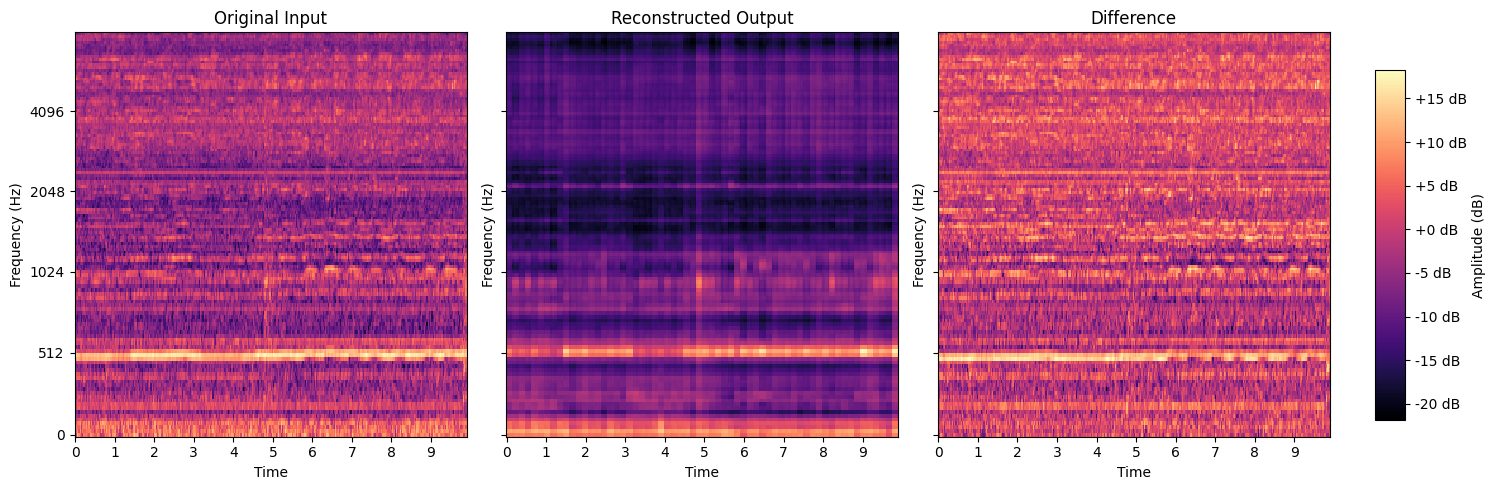

section_00_source_test_anomaly_0020_noAttribute.wav


In [41]:
# Create a horizontal layout for the spectrogram plots
spectrogram_figures, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Plot each spectrogram
spectrograms = [original_input, recreated_output, error_mel]
titles = ['Original Input', 'Reconstructed Output', 'Difference']

for ax, spectrogram, title in zip(axes, spectrograms, titles):
    img = librosa.display.specshow(
        spectrogram,
        sr=16000,
        x_axis='time',
        y_axis='mel',
        cmap='magma',
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency (Hz)')

# Add a colorbar beside the plots
cbar_ax = spectrogram_figures.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = spectrogram_figures.colorbar(img, cax=cbar_ax, format='%+2.0f dB')
cbar.set_label('Amplitude (dB)')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for the color bar
plt.show()

# Print the filename associated with the spectrogram
print(testing_filenames[audio_clip_index])


In [42]:
# # Create a vertical layout for the spectrogram plots
# spectrogram_figures, axes = plt.subplots(3, 1, figsize=(5, 10), sharex=True, sharey=True)

# # Plot each spectrogram
# spectrograms = [original_input, recreated_output, error_mel]
# titles = ['Original Input', 'Reconstructed Output', 'Difference']

# for ax, spectrogram, title in zip(axes, spectrograms, titles):
#     img = librosa.display.specshow(
#         spectrogram,
#         sr=16000,
#         x_axis='time',
#         y_axis='mel',
#         cmap='magma',
#         ax=ax
#     )
#     ax.set_title(title)
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Frequency (Hz)')

# # Add a colorbar beside the plots
# cbar_ax = spectrogram_figures.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# cbar = spectrogram_figures.colorbar(img, cax=cbar_ax, format='%+2.0f dB')
# cbar.set_label('Amplitude (dB)')

# # Adjust layout to prevent overlap
# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on the right for the color bar
# plt.show()

# # Print the filename associated with the spectrogram
# print(testing_filenames[audio_clip_index])

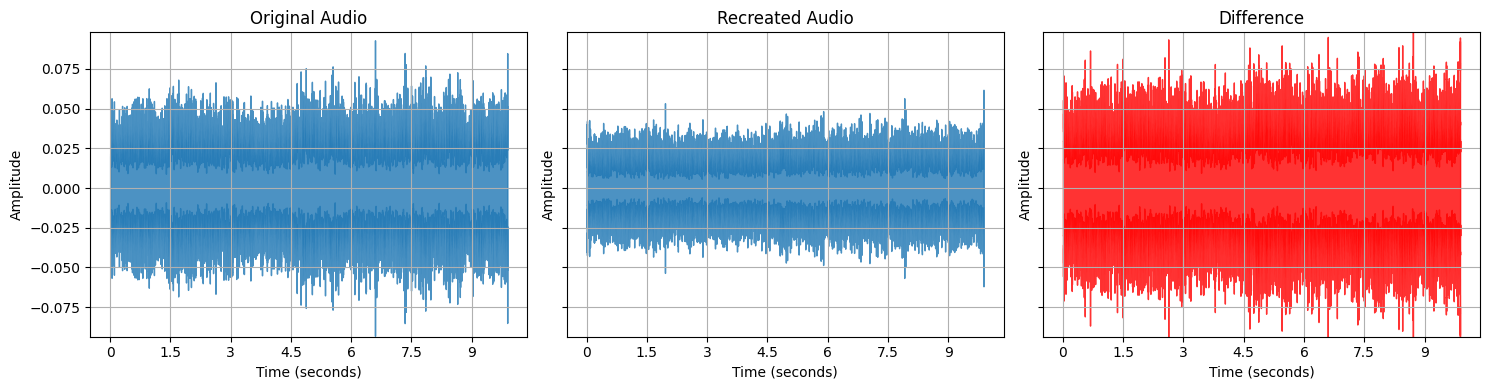

In [43]:
# Generate waveforms for original, recreated, and difference
original_wav = audio_converter.mel_to_wav(original_input)
recreated_wav = audio_converter.mel_to_wav(recreated_output)
difference_wav = original_wav - recreated_wav

# Find global y-axis limits
global_min = min(original_wav.min(), recreated_wav.min(), difference_wav.min())
global_max = max(original_wav.max(), recreated_wav.max(), difference_wav.max())

# Create subplots for waveforms
waveform_figures, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Data and titles for subplots
waveforms = [original_wav, recreated_wav, difference_wav]
titles = ['Original Audio', 'Recreated Audio', 'Difference']

# Plot each waveform
for ax, waveform, title in zip(axes, waveforms, titles):
    if title == 'Difference':  # Check if it's the difference plot
        librosa.display.waveshow(waveform, sr=16000, alpha=0.8, ax=ax, color='red')  # Set color to red
    else:
        librosa.display.waveshow(waveform, sr=16000, alpha=0.8, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_ylim(global_min, global_max)
    ax.grid()


# Adjust layout and display
plt.tight_layout()

In [44]:
import soundfile as sf

# Save the original audio as a .wav file
sf.write("reconstructions/original.wav", original_wav, 16000)

# Save the recreated audio as a .wav file
sf.write("reconstructions/recreated.wav", recreated_wav, 16000)

# Results

## Preparation for Visualization

In [45]:
epochs_range = range(1, epochs + 1)

In [46]:
status_list = []
pattern = r"_(normal|anomaly)_"


for line in testing_filenames:
    match = re.search(pattern, line)
    if match:
        status_list.append(match.group(1))

print(len(status_list))
status_list

200


['anomaly',
 'anomaly',
 'anomaly',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'anomaly',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'anomaly',
 'anomaly',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'anomaly',
 'anomaly',
 'normal',
 'normal',
 'anomaly',
 'anomaly',
 'normal',
 'anomaly',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'normal',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'anomaly',
 'normal',
 'normal',
 'anomaly',
 'anomaly',
 'anomaly',
 'anomaly',
 'normal',
 'normal',
 'anomaly',
 'normal',
 'normal',
 'anomaly',
 'normal',
 'anomaly',
 'anomaly',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'normal',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'normal',
 'anomaly',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'normal',
 'anomaly',
 'normal',
 'normal',
 'normal',
 'normal',
 'anomaly',
 'no

In [47]:
output_with_true_labels = list(zip(status_list, recon_err_per_clip))
print(output_with_true_labels)
sorted_output = sorted(output_with_true_labels, key=lambda x: x[1], reverse=True)
print(sorted_output)
labels, values = zip(*sorted_output)

print(labels)
print(values)

# over_threshold = 0
# for i in range(len(values)):
#     if values[i] > 16.02 and labels[i] == "anomaly":
#         print(values[i])
#         over_threshold += 1

# print(over_threshold)

[('anomaly', np.float32(11.302319)), ('anomaly', np.float32(13.31932)), ('anomaly', np.float32(11.801371)), ('anomaly', np.float32(11.356588)), ('normal', np.float32(13.198959)), ('normal', np.float32(11.333795)), ('normal', np.float32(10.749398)), ('anomaly', np.float32(12.262191)), ('anomaly', np.float32(11.824999)), ('normal', np.float32(10.263254)), ('normal', np.float32(10.4426155)), ('normal', np.float32(21.402166)), ('anomaly', np.float32(10.810494)), ('anomaly', np.float32(12.200148)), ('anomaly', np.float32(15.317503)), ('normal', np.float32(17.689808)), ('anomaly', np.float32(21.258831)), ('normal', np.float32(11.166981)), ('anomaly', np.float32(19.853292)), ('normal', np.float32(13.596815)), ('normal', np.float32(16.069729)), ('normal', np.float32(11.056366)), ('anomaly', np.float32(11.52721)), ('normal', np.float32(16.53798)), ('anomaly', np.float32(12.052213)), ('normal', np.float32(17.184729)), ('anomaly', np.float32(11.071418)), ('anomaly', np.float32(15.17448)), ('norma

In [48]:
colors = ['blue' if label == "normal" else 'red' for label in labels]
print(colors)

binary_labels = [1 if label == 'anomaly' else 0 for label in labels]
print(binary_labels)

['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'red',

In [49]:
shape, loc, scale = gamma.fit(recon_err_per_clip)

x = np.linspace(0, max(values), 1000)
gamma_pdf = gamma.pdf(x, shape, loc=loc, scale=scale)

anomaly_threshold = gamma.ppf(0.9, shape, loc=loc, scale=scale)
# print(f"Anomaly threshold: {anomaly_threshold}")

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [51]:
anomaly_labels = (values > anomaly_threshold).astype(int)

cm = confusion_matrix(binary_labels, anomaly_labels.astype(int))

TN, FP, FN, TP = cm.ravel()

fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
accuracy = (TP + TN) / (TP + TN + FP + FN)

In [52]:
roc_fpr, roc_tpr, thresholds = roc_curve(binary_labels, values)
auc_score = auc(roc_fpr, roc_tpr)
auc_score_2 = roc_auc_score(binary_labels, values)
print(f"AUC: {auc_score}")
print(f"AUC 2: {auc_score_2}")
thresholds

AUC: 0.5223
AUC 2: 0.5223


array([       inf, 28.560068 , 22.305979 , 21.402166 , 19.302639 ,
       19.140652 , 17.714516 , 17.184729 , 17.104353 , 16.763706 ,
       16.595484 , 16.53798  , 16.485209 , 16.017902 , 15.803262 ,
       15.613316 , 14.72314  , 14.512802 , 14.492344 , 14.100743 ,
       14.025397 , 13.973425 , 13.878372 , 13.617742 , 13.598647 ,
       13.546045 , 13.200534 , 13.198959 , 13.1283455, 12.946613 ,
       12.906942 , 12.808197 , 12.73421  , 12.699808 , 12.698976 ,
       12.658575 , 12.588255 , 12.559403 , 12.523419 , 12.350791 ,
       12.296611 , 12.278443 , 12.200148 , 12.080051 , 12.047262 ,
       11.948666 , 11.938107 , 11.906201 , 11.904236 , 11.861168 ,
       11.801371 , 11.779101 , 11.724012 , 11.695864 , 11.648857 ,
       11.603096 , 11.560593 , 11.536609 , 11.467541 , 11.458633 ,
       11.444029 , 11.393755 , 11.349132 , 11.344909 , 11.339063 ,
       11.3173685, 11.284653 , 11.284613 , 11.238559 , 11.233623 ,
       11.191291 , 11.166981 , 11.059075 , 11.056366 , 11.0182

In [53]:
j_scores = roc_tpr - roc_fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold}")

Best threshold: 17.714515686035156


In [54]:
p = 0.1

# Get indices where FPR <= p
valid_indices = roc_fpr <= p

# Check if any values meet the condition
if not np.any(valid_indices):
    print(f"No FPR values are <= {p}. pAUC cannot be calculated.")
else:
    # Slice FPR and TPR arrays
    fpr_p = roc_fpr[valid_indices]
    tpr_p = roc_tpr[:len(fpr_p)]

    # Calculate pAUC
    pauc_score = auc(fpr_p, tpr_p)
    print(f"pAUC: {pauc_score}")

pAUC: 0.012900000000000002


In [55]:
final_score = 2 * (np.mean(auc_score) * np.mean(pauc_score)) / (np.mean(auc_score) + np.mean(pauc_score))
final_score

np.float64(0.025178139013452918)

# Visualizations

In [56]:
# #> for random training_losses if missing
# import numpy as np

# np.random.seed(42)
# epochs_range = np.arange(1, 51)
# training_losses = np.round(np.linspace(0.5, 0.1, len(epochs_range)) + np.random.normal(0, 0.02, len(epochs_range)), 3)

# training_losses

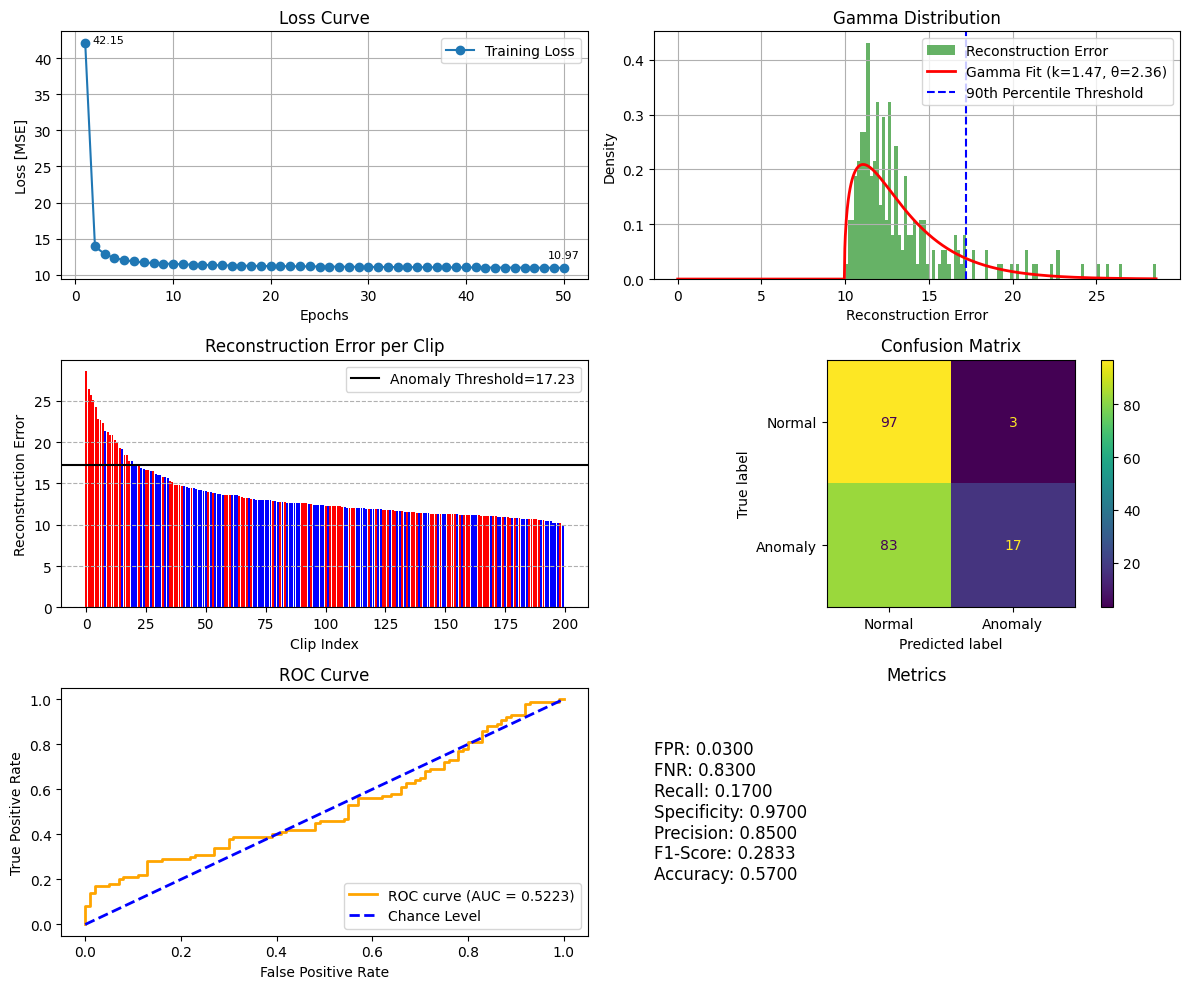

In [57]:
combined_results_figure, axes = plt.subplots(3,2, figsize=(12, 10))
axes = axes.flatten()


#> Loss Curve
axes[0].plot(epochs_range, training_losses, label='Training Loss', marker='o')
axes[0].annotate(
    f'{training_losses[0]:.2f}',
    (epochs_range[0], training_losses[0]),
    textcoords="offset points",
    xytext=(5,0),
    ha='left',
    fontsize=8
)
axes[0].annotate(
    f'{training_losses[-1]:.2f}',
    (epochs_range[-1], training_losses[-1]),
    textcoords="offset points",
    xytext=(0,7),
    ha='center',
    fontsize=8
)
axes[0].set_title('Loss Curve')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss [MSE]')
axes[0].legend()
axes[0].grid()


#> Gamma Distribution
axes[1].hist(values, bins=100, density=True, color='green', alpha=0.6, label='Reconstruction Error')
axes[1].plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma Fit (k={shape:.2f}, θ={scale:.2f})')
axes[1].axvline(gamma.ppf(0.90, shape, loc=loc, scale=scale), color='b', linestyle='--', label='90th Percentile Threshold')
axes[1].set_title('Gamma Distribution')
axes[1].set_xlabel('Reconstruction Error')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True)


#> Reconstruction Errors
axes[2].axhline(y=anomaly_threshold, color='black', linestyle='-', label=f'Anomaly Threshold={anomaly_threshold:.2f}')
axes[2].bar(range(len(values)), values, color=colors)
axes[2].set_title('Reconstruction Error per Clip')
axes[2].set_xlabel('Clip Index')
axes[2].set_ylabel('Reconstruction Error')
axes[2].legend()
axes[2].grid(axis='y', linestyle='--')


#> Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap='viridis', ax=axes[3])
axes[3].set_title("Confusion Matrix")


#> ROC Curve
axes[4].plot(roc_fpr, roc_tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
axes[4].plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Chance Level')
axes[4].set_title('ROC Curve')
axes[4].set_xlabel('False Positive Rate')
axes[4].set_ylabel('True Positive Rate')
axes[4].legend(loc='lower right')
axes[1].grid(True)


#> Metrics
metrics = f"FPR: {fpr:.4f}\nFNR: {fnr:.4f}\nRecall: {recall:.4f}\nSpecificity: {specificity:.4f}\nPrecision: {precision:.4f}\nF1-Score: {f1_score:.4f}\nAccuracy: {accuracy:.4f}"""
axes[5].axis('off')
axes[5].text(0, 0.5, metrics, fontsize=12, va='center', wrap=True)
axes[5].set_title("Metrics")


#> Show the plots
combined_results_figure.tight_layout()
plt.show()

In [58]:
# anomaly_labels = (values > best_threshold).astype(int)

# cm = confusion_matrix(binary_labels, anomaly_labels.astype(int))

# TN, FP, FN, TP = cm.ravel()

# fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
# fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
# recall = TP / (TP + FN) if (TP + FN) > 0 else 0
# specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
# precision = TP / (TP + FP) if (TP + FP) > 0 else 0
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
# accuracy = (TP + TN) / (TP + TN + FP + FN)

In [59]:
# combined_results_figure, axes = plt.subplots(3,2, figsize=(12, 10))
# axes = axes.flatten()


# #> Loss Curve
# axes[0].plot(epochs_range, training_losses, label='Training Loss', marker='o')
# axes[0].annotate(
#     f'{training_losses[0]:.2f}',
#     (epochs_range[0], training_losses[0]),
#     textcoords="offset points",
#     xytext=(5,0),
#     ha='left',
#     fontsize=8
# )
# axes[0].annotate(
#     f'{training_losses[-1]:.2f}',
#     (epochs_range[-1], training_losses[-1]),
#     textcoords="offset points",
#     xytext=(0,7),
#     ha='center',
#     fontsize=8
# )
# axes[0].set_title('Loss Curve')
# axes[0].set_xlabel('Epochs')
# axes[0].set_ylabel('Loss [MSE]')
# axes[0].legend()
# axes[0].grid()


# #> Gamma Distribution
# axes[1].hist(values, bins=100, density=True, color='green', alpha=0.6, label='Reconstruction Error')
# axes[1].plot(x, gamma_pdf, 'r-', lw=2, label=f'Gamma Fit (k={shape:.2f}, θ={scale:.2f})')
# axes[1].axvline(gamma.ppf(0.90, shape, loc=loc, scale=scale), color='b', linestyle='--', label='90th Percentile Threshold')
# axes[1].set_title('Gamma Distribution')
# axes[1].set_xlabel('Reconstruction Error')
# axes[1].set_ylabel('Density')
# axes[1].legend()
# axes[1].grid(True)


# #> Reconstruction Errors
# axes[2].axhline(y=best_threshold, color='black', linestyle='-', label=f'Anomaly Threshold={best_threshold:.2f}')
# axes[2].bar(range(len(values)), values, color=colors)
# axes[2].set_title('Reconstruction Error per Clip')
# axes[2].set_xlabel('Clip Index')
# axes[2].set_ylabel('Reconstruction Error')
# axes[2].legend()
# axes[2].grid(axis='y', linestyle='--')


# #> Confusion Matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
# disp.plot(cmap='viridis', ax=axes[3])
# axes[3].set_title("Confusion Matrix")


# #> ROC Curve
# axes[4].plot(roc_fpr, roc_tpr, color='orange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
# axes[4].plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Chance Level')
# axes[4].set_title('ROC Curve')
# axes[4].set_xlabel('False Positive Rate')
# axes[4].set_ylabel('True Positive Rate')
# axes[4].legend(loc='lower right')
# axes[1].grid(True)


# #> Metrics
# metrics = f"FPR: {fpr:.4f}\nFNR: {fnr:.4f}\nRecall: {recall:.4f}\nSpecificity: {specificity:.4f}\nPrecision: {precision:.4f}\nF1-Score: {f1_score:.4f}\nAccuracy: {accuracy:.4f}"""
# axes[5].axis('off')
# axes[5].text(0, 0.5, metrics, fontsize=12, va='center', wrap=True)
# axes[5].set_title("Metrics")


# #> Show the plots
# combined_results_figure.tight_layout()
# plt.show()

# Saving Model and Results

In [60]:
folder_name = "saved_models"
os.makedirs(folder_name, exist_ok=True)

existing_files = [f for f in os.listdir(folder_name) if f.endswith('.pth')]
file_number = len(existing_files) + 1
pth_filename = os.path.join(folder_name, f"saved_model_{file_number}.pth")

torch.save(model.state_dict(), pth_filename)

In [61]:
#> Preparing folder and filename for PDF
folder_name = "training_results"
os.makedirs(folder_name, exist_ok=True)
existing_files = [f for f in os.listdir(folder_name) if f.endswith(".pdf")]
file_number = len(existing_files) + 1
pdf_filename = os.path.join(folder_name, f"training_results_{file_number}.pdf")


#> Model Structure
model_structure_string = str(model)
model_structure_figure, ms_axes = plt.subplots()
ms_axes.axis('off')
ms_axes.text(0, 0.5, model_structure_string, fontsize=7, va='center', wrap=True)
ms_axes.set_title("Model Structure")


#> Hyperparameters
hyper_parameters_string = yaml.dump(hyper_parameters, default_flow_style=False)
hyper_parameters_figure, hpf_axes = plt.subplots()
hpf_axes.axis('off')
hpf_axes.text(0.5, 0.5, hyper_parameters_string, fontsize=12, va='center', ha='center', wrap=True)
hpf_axes.set_title("Hyperparameters")


#> Save all figures to a single PDF
with PdfPages(pdf_filename) as pdf:
    pdf.savefig(combined_results_figure)
    pdf.savefig(spectrogram_figures)
    pdf.savefig(waveform_figures)
    pdf.savefig(hyper_parameters_figure)
    pdf.savefig(model_structure_figure)
    plt.close('all')